# Amazon Reviews Modelling Using BERT with Noisy Labels

# 1. Install and Import Necessary Libray For NLP and Sentiment Analysis

In [2]:
%%capture
!pip install stopwords
!pip install flair
!pip install nltk
!pip install swifter

In [3]:
!pip install --upgrade pyarrow

In [4]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random as rn
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

pd.options.display.max_rows = None
seed=40

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# 2. Import Amazon Reviews Dataset

In [5]:
rn.seed(a=40)
review = pd.read_csv('../input/amazon-product-reviews/Reviews.csv')
review.shape

(568454, 10)

In [6]:
review.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
def score_round(x):
    if x>=3:
        return 1
    else: 
        return 0
review['review_score']= review.Score.apply(score_round)
review = review.rename(columns={'Text':'review_text'})
df=review.copy()

In [8]:
df['review_score'].value_counts()

1    486417
0     82037
Name: review_score, dtype: int64

In [9]:
zeroes=df[review['review_score']==0].head(30000)
ones=df[review['review_score']==1].head(20000)

In [10]:
d=pd.concat([zeroes,ones])

In [11]:
d.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,review_text,review_score
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
12,13,B0009XLVG0,A327PCT23YH90,LT,1,1,1,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...,0
16,17,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,2,1348099200,poor taste,I love eating them and they are good for watch...,0
26,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,1,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan...",0


In [12]:
df['review_score'].value_counts()

1    486417
0     82037
Name: review_score, dtype: int64

In [13]:
df=d.copy()
df=df.sample(frac=1).reset_index(drop=True)
df.head()
import pandas as pd
import numpy as np
num_rows_to_shuffle = int(0.4 * len(df))
np.random.seed(0)  
indices_to_shuffle = np.random.choice(df.index[1:], size=num_rows_to_shuffle, replace=False)

In [14]:
len(indices_to_shuffle)

20000

In [15]:
d=df.copy()

In [16]:
d['review_score'].value_counts()

0    30000
1    20000
Name: review_score, dtype: int64

In [17]:
for idx in indices_to_shuffle:
    if df['review_score'].loc[idx]==1:
        df.at[idx,'review_score']=0
    elif df['review_score'].loc[idx]==0:
        df.at[idx,'review_score']=1
    else:
        print('no invalid value')

In [18]:
df['review_score'].value_counts()

0    26004
1    23996
Name: review_score, dtype: int64

In [19]:
review=df.copy()

In [20]:
# review.review_score.replace("positive" , 1 , inplace = True)
# review.review_score.replace("negative" , 0 , inplace = True)

In [21]:
review.review_text = review.review_text.astype('str')
review.Summary = review.Summary.astype('str')

# 3. Analysis and Visualization

In [22]:
temp = review.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_text',ascending=False)
temp.style.background_gradient(cmap='Purples')


,review_score,review_text
0,0,26004
1,1,23996


<AxesSubplot:xlabel='review_score', ylabel='count'>

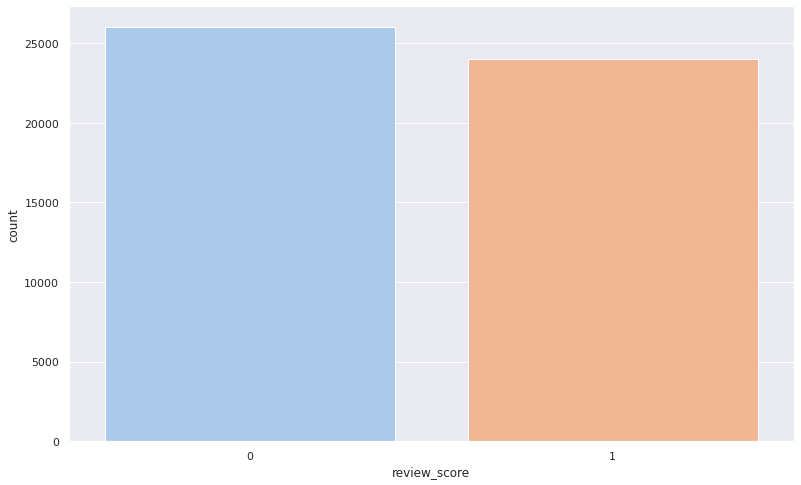

In [23]:
sns.set_theme(style='whitegrid')
sns.set(rc = {'figure.figsize':(13,8)})
sns.set_palette("pastel")
sns.countplot(x='review_score',data=review)

## WordCloud of entire Review Text

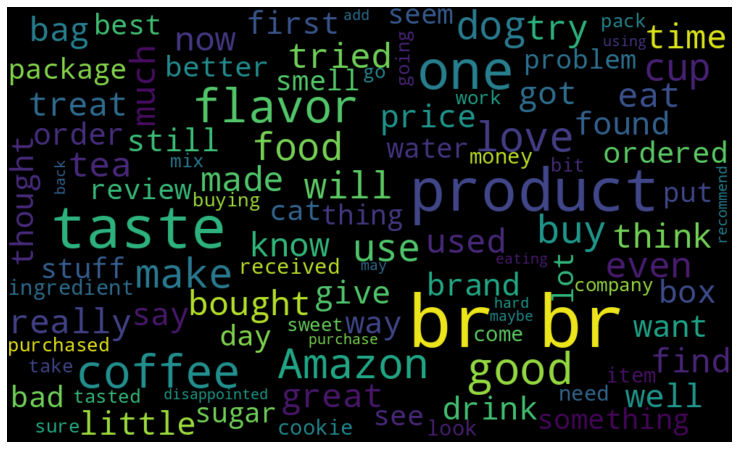

In [25]:
txt = ' '.join(rev for rev in review.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

## WordCloud of Each Sentiment Review

In [26]:
positive = review[review['review_score']==1]
negative = review[review['review_score']==0]

## Positive Sentiment Text and Summary Reviews

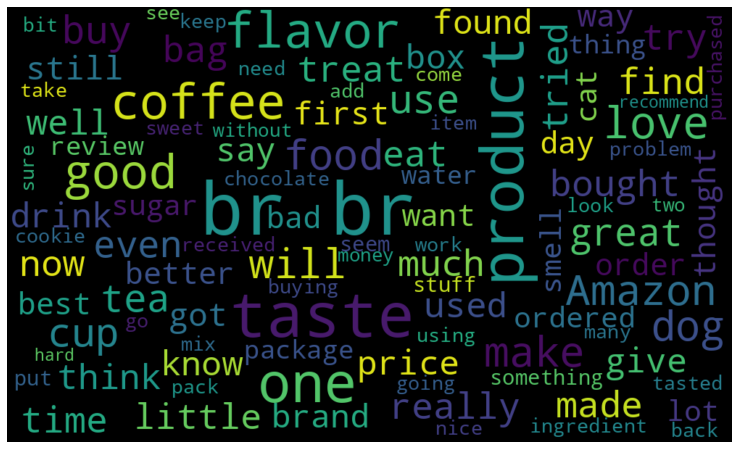

In [27]:
txt = ' '.join(rev for rev in positive.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

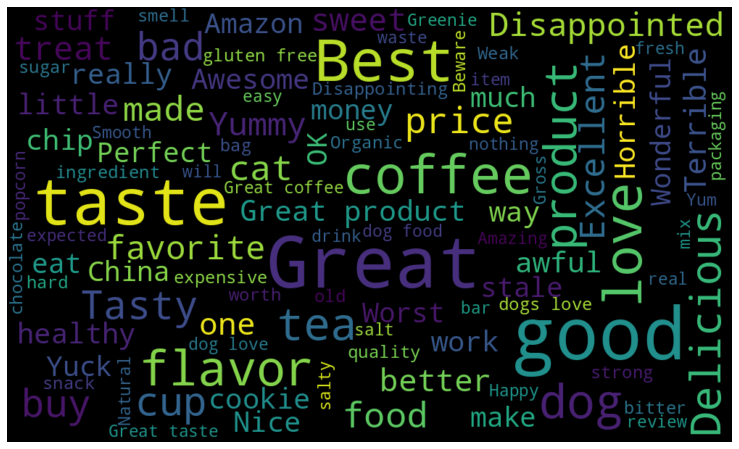

In [28]:
txt = ' '.join(rev for rev in positive.Summary)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

## Negative Sentiment Reviews

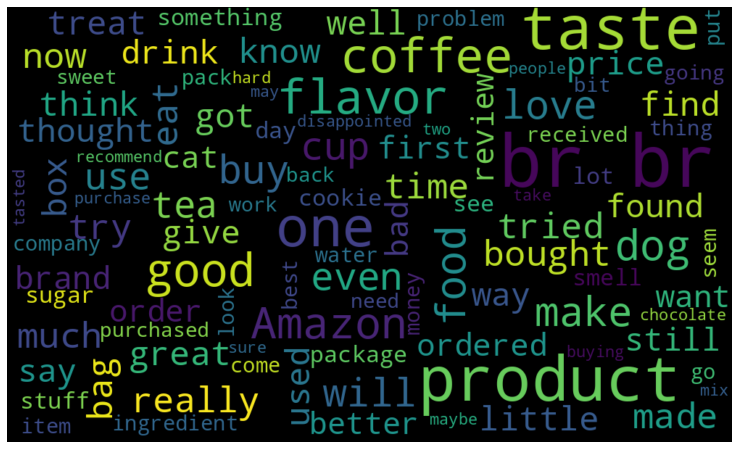

In [29]:
txt = ' '.join(rev for rev in negative.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

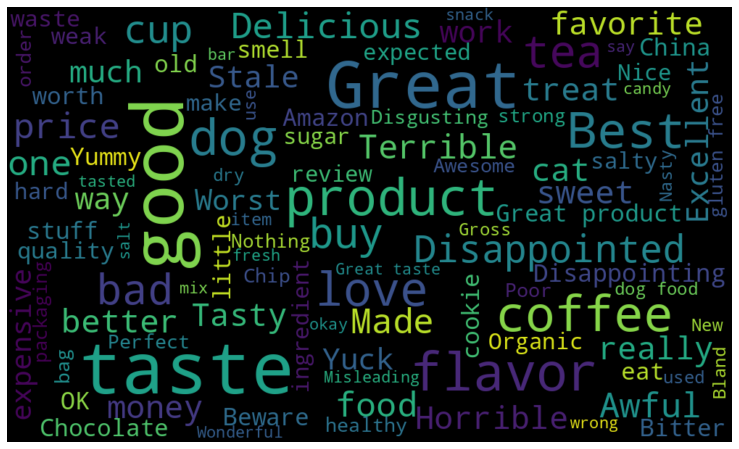

In [30]:
txt = ' '.join(rev for rev in negative.Summary)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

### This still contains stopwords which needs to be filtered.

# 4. Data Cleaning For Sentiment Processing

In [32]:
review['review_text'] = review['review_text'].str.replace(' br ','')

In [33]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Null values Cleaning

In [34]:
review.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               2
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
review_text               0
review_score              0
dtype: int64

### Duplicate Values Removing

In [35]:
review = review.drop_duplicates(keep='first')

In [36]:
review.shape

(50000, 11)

In [37]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

In [38]:
def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output

In [39]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

In [40]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string 

In [41]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string

In [42]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

In [43]:
stop=set(stopwords.words("english"))
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

def remove_stopword(text):
   text=[word.lower() for word in text.split() if word.lower() not in stop]
   return " ".join(text)

In [44]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
def Stemming(text):
   stem=[]
   stopword = stopwords.words('english')
   snowball_stemmer = SnowballStemmer('english')
   word_tokens = nltk.word_tokenize(text)
   stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
   stem=' '.join(stemmed_word)
   return stem

In [45]:
def cleaning(df,review):
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)

In [46]:
cleaning(review,'review_text')

In [47]:
review.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               2
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
review_text               0
review_score              0
dtype: int64

In [48]:
review[['review_text']].head(20)

,review_text
0,purchased one pound brand stevia extract overl...
1,layers spin easily year old female weimaraner ...
2,bought thought actually organic ingredients de...
3,taste great gave terrible migraine msg sensiti...
4,regular size one recently purchased x small ha...
5,order snack sticks amazon decided give review ...
6,opened product find lollipops broke disappoint...
7,syrup organic pure maple syrup tastes great do...
8,wonderful little chocolate bits need look bit ...
9,great concept poor result oily dense slightly ...


In [49]:
review_vis2 = review.copy()

In [50]:
review_vis2['temp_list'] = review_vis2['review_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis2['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,br,61752
1,like,25282
2,taste,17426
3,product,16776
4,one,16409
5,coffee,16282
6,good,15444
7,would,14303
8,food,12691
9,flavor,12359


<AxesSubplot:xlabel='count', ylabel='Common_words'>

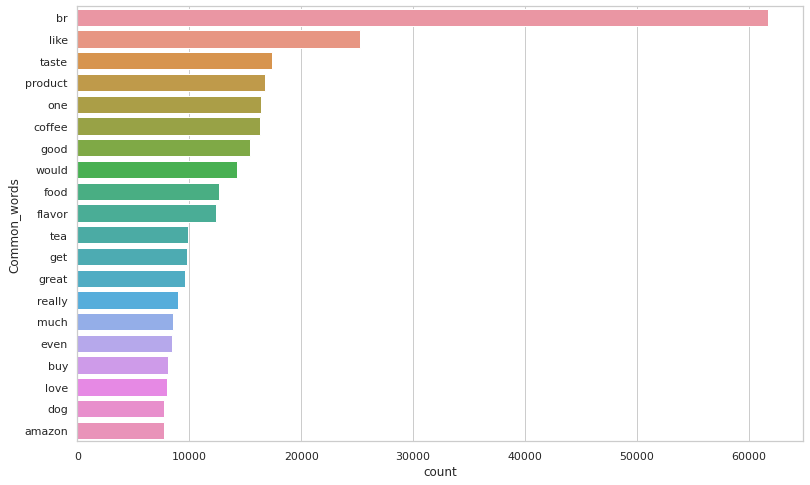

In [51]:
sns.set_theme(style="whitegrid")
sns.barplot(x="count", y="Common_words", data=temp)

# 5. BERT Tokenizing and Modelling

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tokenizers import BertWordPieceTokenizer

import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

import logging
transformers.logging.set_verbosity_error()


In [53]:
reviews = review["review_text"].values.tolist()
labels = review["review_score"].tolist()

In [54]:
# split the dataset into train, validation and holdout sets (60-20-20)
training_sentences, test_sentences, training_labels, test_labels = train_test_split(reviews, labels, test_size=.4)

validation_sentences, holdout_sentences, validation_labels, holdout_labels = train_test_split(test_sentences, test_labels, test_size=.5)

In [55]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [56]:
# Example of the tokenizer output
tokenizer([training_sentences[0]], truncation=True,
                            padding=True, max_length=512)

{'input_ids': [[101, 1141, 5095, 176, 25937, 1424, 1714, 7738, 1185, 27267, 1250, 1277, 1618, 176, 2087, 1185, 27267, 2215, 2991, 1256, 1231, 2087, 17305, 20725, 3264, 1543, 2504, 1185, 27267, 10514, 1567, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [57]:
train_encodings = tokenizer(training_sentences,
                            truncation=True,
                            padding=True)

validation_encodings = tokenizer(validation_sentences,
                            truncation=True,
                            padding=True)

holdout_encodings = tokenizer(holdout_sentences,
                            truncation=True,
                            padding=True)

In [58]:
train_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(train_encodings),
                            training_labels
                            ));

validation_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(validation_encodings),
                            validation_labels
                            ));

holdout_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(holdout_encodings),
                            holdout_labels
                            ));

In [59]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-cased',num_labels=2)

In [60]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

In [61]:
history = model.fit(train_dataset.shuffle(100).batch(8),
          epochs=3,
          batch_size=8,
          validation_data=validation_dataset.shuffle(100).batch(8), verbose=1)

Epoch 1/3


/opt/conda/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:376: FutureWarning: The old compute_loss method is deprecated as it conflicts with the Keras compute_loss method added in TF 2.8. If you want the original HF compute_loss, please call hf_compute_loss() instead. From TF versions >= 2.8, or Transformers versions >= 5, calling compute_loss() will get the Keras method instead.
  return py_builtins.overload_of(f)(*args)


3750/3750 [==============================] - 2395s 633ms/step - loss: 0.6933 - accuracy: 0.5314 - val_loss: 0.7049 - val_accuracy: 0.5139
Epoch 2/3
3750/3750 [==============================] - 2372s 633ms/step - loss: 0.6843 - accuracy: 0.5643 - val_loss: 0.7004 - val_accuracy: 0.5281
Epoch 3/3
3750/3750 [==============================] - 2374s 633ms/step - loss: 0.6600 - accuracy: 0.6175 - val_loss: 0.7180 - val_accuracy: 0.5410


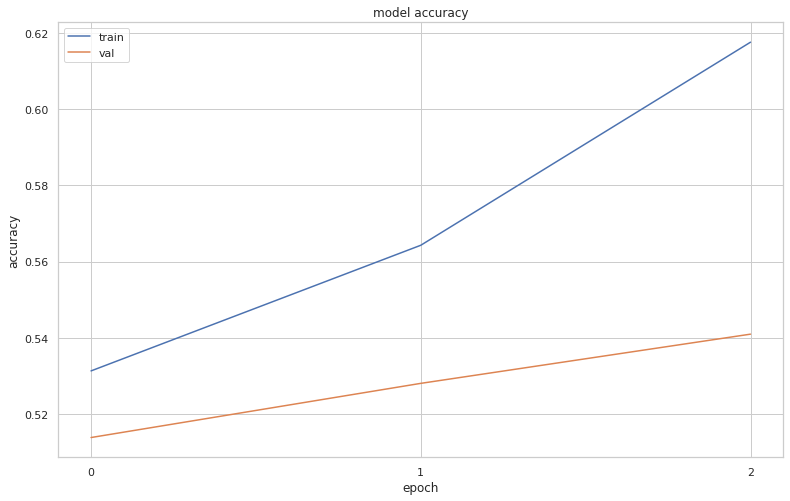

In [62]:
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [63]:
model.save_pretrained("./output_model")

In [64]:
loaded_model = TFBertForSequenceClassification.from_pretrained("./output_model")
result = model.evaluate(holdout_dataset.batch(8))
dict(zip(model.metrics_names, result))

1250/1250 [==============================] - 248s 198ms/step - loss: 0.7114 - accuracy: 0.5541


{'loss': 0.7114312648773193, 'accuracy': 0.554099977016449}

### The model's accuracy 55.40% on our holdout set (other validation set)

In [65]:
tf_output = loaded_model.predict(holdout_dataset.batch(8))
pred_label = tf.argmax(tf.nn.softmax(tf_output["logits"], axis=1).numpy(), 1).numpy()

In [66]:
cm = tf.math.confusion_matrix(
    holdout_labels, pred_label, num_classes=2, weights=None, dtype=tf.dtypes.int32,
    name=None
).numpy()

print("confusion matrix\n",cm)

confusion matrix
 [[4171 1095]
 [3364 1370]]


### With 40% noisy labels, the confusion matrix indicates that the model faces challenges in accurately distinguishing between positive and negative instances, resulting in higher rates of false positives and false negatives.

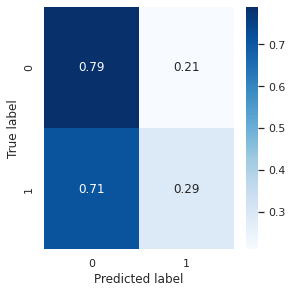

In [67]:
cm_norm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

cm_df = pd.DataFrame(cm_norm,
                 index = [0,1], 
                 columns =[0,1])

figure = plt.figure(figsize=(4, 4))
sns.heatmap(cm_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [68]:
tp = cm[0][0]
fn = cm[0][1]

tn = cm[1][1]
fp = cm[1][0]

recall = round(tp / (tp+fn), 2)
precision = round(tp / (tp+fp), 2)
f1score = (2*precision*recall) / (precision + recall)

print("recall score:", recall)
print("precision score:", precision)
print("F1-Score:",f1score)

recall score: 0.79
precision score: 0.55
F1-Score: 0.6485074626865672


### An F1-Score of 0.6485 suggests that the model achieves a moderate balance between precision and recall, considering the presence of 40% noisy labels in the dataset.